In [1]:
# %gui qt6

# # Qt6 stuff
# from PyQt6.QtWidgets import QApplication
# from PyQt6 import QtWidgets
# from PyQt6 import QtGui
# from PyQt6 import QtCore
# from PyQt6.QtCore import pyqtSignal

# Plotting stuff
import pyqtgraph as pg
import matplotlib.pyplot as plt
import cmasher as cmr
from astropy.visualization import ZScaleInterval, imshow_norm

# Science stuff
import numpy as np
import pandas as pd
from spectres import spectres
from scipy.signal import find_peaks

# Astropy stuff
from astropy.io import fits
from astropy.table import Table
import astropy.units as u
from astropy.units.quantity import Quantity
from astropy.io.ascii import read as ascii_read

# zHunter stuff
from zhunter import DIRS
from zhunter import io
import zhunter.misc as msc
from zhunter.colors import get_gradient
from zhunter.spectroscopic_system import SpecSystemModel, SpecSystem

# astropalmerio stuff
import astropalmerio.spectra as sp
import astropalmerio.galaxies as gal
import astropalmerio.mc as mc

# General stuff
import logging
import sys
from pathlib import Path
from itertools import cycle

In [2]:
# Logging
log = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG,
                    format='%(asctime)s %(levelname)s [%(name)s] %(message)s')
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger("PIL").setLevel(logging.WARNING)

In [3]:
plt.style.use('paper')
plt.style.use('kraken')
colors = cmr.take_cmap_colors('Spectral', 10, cmap_range=(0.0, 1), return_fmt='hex')

In [22]:
hdul = fits.open(fname_2D)
hdul[0].header['CUNIT1'] = 'Angstrom'


In [25]:
hdul[0].header

SIMPLE  =                    T / Standard FITS format: NOST 100-2.0             
BITPIX  =                  -32 / No. of bits per pixel                          
NAXIS   =                    2 / No. of axes in image                           
NAXIS1  =                 2048 / No. of pixels                                  
NAXIS2  =                   61 / No. of pixels                                  
EXTEND  =                    T / FITS extension may be present                  
                                                                                
                                                                                
CRPIX1  =                   1. / Reference pixel                                
CRVAL1  =         4126.2271821 / Coordinate at reference pixel                  
CDELT1  =        1.99711922763 / Coord. incr. per pixel (original value)        
CTYPE1  = '                '   / Units of coordinate                            
CRPIX2  =                -48

In [24]:
hdul.writeto('/Users/palmerio/Downloads/net_unit.fits', overwrite=True)

In [9]:
# fname_2D = Path('/Users/palmerio/Science_projects/Reduced_data/GRB230325A/xsh_scired_slit_nod_SCI_SLIT_FLUX_MERGE2D_NIR_NIR_x_.fits')
fname_2D = Path('/Users/palmerio/Downloads/net.fits')

wvlg, spat, flux, unc, header = io.read_fits_2D_spectrum(fname_2D)
wvlg = wvlg.value
spat = spat.value
flux = flux.value
unc = unc.value
# unc = unc+1

2023-05-09 17:12:27,541 INFO [zhunter.io] Attempting to read file: /Users/palmerio/Downloads/net.fits
2023-05-09 17:12:27,546 DEBUG [zhunter.io] Did not find any name matching ['FLUX', 'SCI'] in ['PRIMARY']
2023-05-09 17:12:27,547 DEBUG [zhunter.io] Couldn't find an HDU with a name containing any of ['FLUX', 'SCI']. Looking for primary or image HDUs containing 2D arrays
2023-05-09 17:12:27,570 DEBUG [zhunter.io] Found HDU: PRIMARY which contains a 2D array
2023-05-09 17:12:27,571 DEBUG [zhunter.io] Did not find any name matching ['ERR', 'NOISE', 'SIGMA', 'UNC'] in ['PRIMARY']
2023-05-09 17:12:27,572 DEBUG [zhunter.io] Couldn't find an HDU with a name containing any of ['ERR', 'NOISE', 'SIGMA', 'UNC']. Setting errors/uncertainties to 0.
2023-05-09 17:12:27,574 INFO [zhunter.io] No unit found in header, assuming arcsec
2023-05-09 17:12:27,575 DEBUG [zhunter.io] Using the FITS CDELT value.
2023-05-09 17:12:27,575 DEBUG [zhunter.io] PIX=-488.0 VAL=1.0 DELT=1.0
2023-05-09 17:12:27,576 INFO 

In [5]:
def rebin_1D(spectrum, bin_width=2):
    new_bin_count = len(spectrum) // bin_width
    # This drops the end of the spectrum if the length of the
    # spectrum is not a multiple of bin_width
    spectrum_2d = spectrum[:new_bin_count*bin_width].reshape(new_bin_count, bin_width)
    rebinned_spectrum = np.mean(spectrum_2d, axis=1)
    return rebinned_spectrum
def get_observing_conditions(header):
    try:
        fwhm_mean = np.nanmean([header['ESO TEL AMBI FWHM START'],header['ESO TEL AMBI FWHM END']])
        airmass_mean = np.nanmean([header['ESO TEL AIRM START'],header['ESO TEL AIRM END']])
        seeing_mean = fwhm_mean * (airmass_mean)**(3/5)  # From Jonatan Selsing's post-processing scripts
    except KeyError:
        log.error("Could not get seeing and airmass from header.")
    return fwhm_mean, airmass_mean, seeing_mean
fwhm, airmass, seeing = get_observing_conditions(header)
seeing_px = seeing/header['CDELT2']
print(f"Observing conditions: fwhm = {fwhm:.3f}\", airmass = {airmass:.3f}, seeing = {seeing:.3f}\", {seeing_px:.3f} pix ")

Observing conditions: fwhm = 0.930", airmass = 1.373, seeing = 1.125", 5.355 pix 


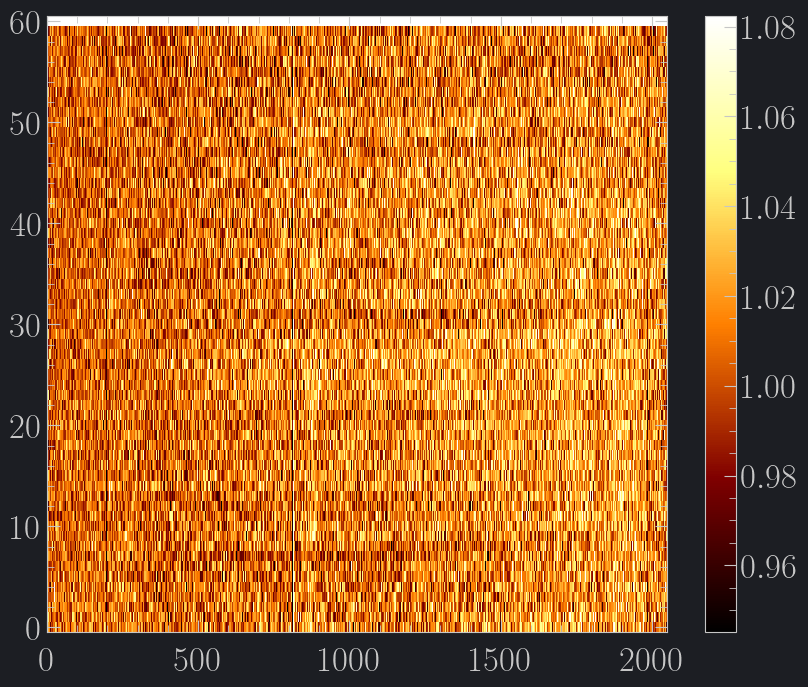

In [6]:
fig, ax = plt.subplots()
# Plot 2D
im, norm = imshow_norm(flux, ax=ax, aspect='auto', origin='lower', 
                       interval=ZScaleInterval(contrast=0.5),
                       cmap='afmhot',
                       interpolation='none')
plt.colorbar(im)

plt.show()

In [7]:
header

SIMPLE  =                    T / Standard FITS format: NOST 100-2.0             
BITPIX  =                  -32 / No. of bits per pixel                          
NAXIS   =                    2 / No. of axes in image                           
NAXIS1  =                 2048 / No. of pixels                                  
NAXIS2  =                   61 / No. of pixels                                  
EXTEND  =                    T / FITS extension may be present                  
                                                                                
                                                                                
CRPIX1  =                   1. / Reference pixel                                
CRVAL1  =         4126.2271821 / Coordinate at reference pixel                  
CDELT1  =        1.99711922763 / Coord. incr. per pixel (original value)        
CTYPE1  = '                '   / Units of coordinate                            
CRPIX2  =                -48

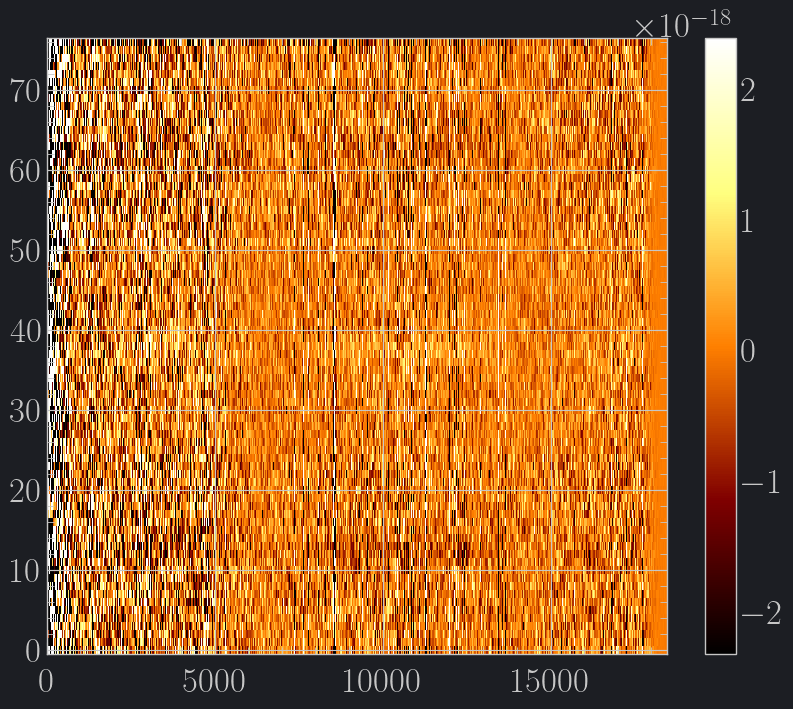

In [7]:
fig, ax = plt.subplots()
# Plot 2D
im, norm = imshow_norm(flux, ax=ax, aspect='auto', origin='lower', 
                       interval=ZScaleInterval(contrast=0.5),
                       cmap='afmhot',
                       interpolation='none')
plt.colorbar(im)

plt.show()

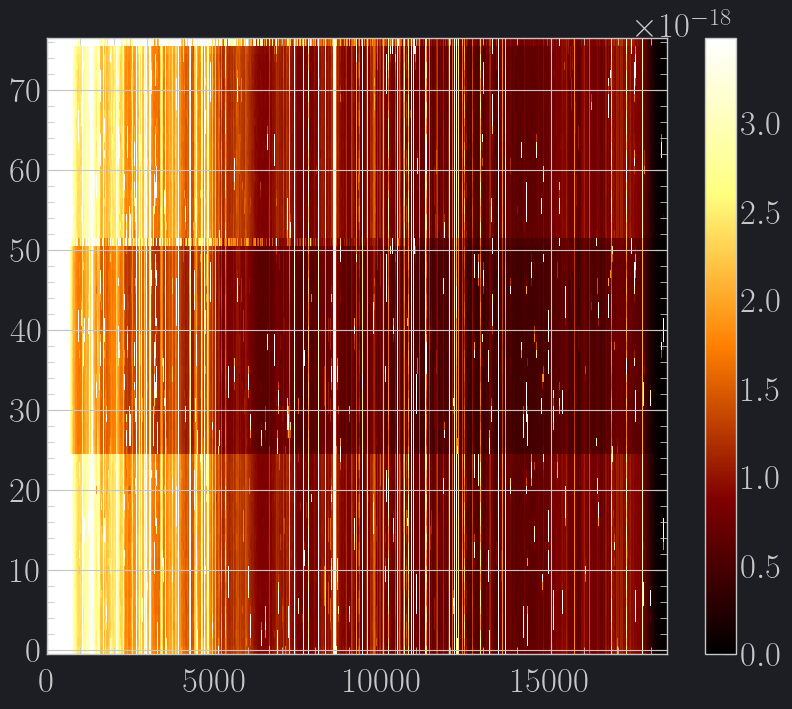

In [8]:
fig, ax = plt.subplots()
# Plot 2D
im, norm = imshow_norm(unc, ax=ax, aspect='auto', origin='lower', 
                       interval=ZScaleInterval(contrast=0.5),
                       cmap='afmhot',
                       interpolation='none')
plt.colorbar(im)

plt.show()

In [13]:
nypix = header['NAXIS2']
nxpix = header['NAXIS1']
cdelt1 = header['CDELT1']
cdelt2 = header['CDELT2']
cen_reg_low = int(nypix/2 - seeing_px)
cen_reg_upp = int(nypix/2 + seeing_px)
sky_reg_upp = int(cen_reg_low - 1.5*seeing_px)
sky_reg_low = int(sky_reg_upp - 1*seeing_px)

NameError: name 'seeing_px' is not defined

## Bin 2D flux array in wavelength dimension

In [16]:
n_bins = 10
pixel_bin_edges = np.linspace(0, flux.shape[1]-1, n_bins+1, dtype=int)
SNR_binned = np.zeros((flux.shape[0], n_bins))
wvlg_bins_med = np.zeros(n_bins)
for i in range(0,n_bins):
    pix_beg, pix_end = pixel_bin_edges[i], pixel_bin_edges[i+1]
    wvlg_bins_med[i] = 0.5*(wvlg[pix_beg]+wvlg[pix_end])
    log.info(f"Calculating median SNR between {wvlg[pix_beg]:.2f} and {wvlg[pix_end]:.2f} nm ({pix_beg} - {pix_end} px)")
    # Use SNR here because its better when using the find_peaks function of scipy
    # Also use the median to avoid contamination from very strong pixels
    SNR_binned[:,i] = np.nanmedian(flux[:,pix_beg:pix_end]/unc[:,pix_beg:pix_end],axis=1)
    

2023-05-09 17:15:34,211 INFO [__main__] Calculating median SNR between 4126.23 and 4533.64 nm (0 - 204 px)
2023-05-09 17:15:34,215 INFO [__main__] Calculating median SNR between 4533.64 and 4943.05 nm (204 - 409 px)
2023-05-09 17:15:34,218 INFO [__main__] Calculating median SNR between 4943.05 and 5352.46 nm (409 - 614 px)
2023-05-09 17:15:34,221 INFO [__main__] Calculating median SNR between 5352.46 and 5759.87 nm (614 - 818 px)
2023-05-09 17:15:34,223 INFO [__main__] Calculating median SNR between 5759.87 and 6169.28 nm (818 - 1023 px)
2023-05-09 17:15:34,226 INFO [__main__] Calculating median SNR between 6169.28 and 6578.69 nm (1023 - 1228 px)
2023-05-09 17:15:34,228 INFO [__main__] Calculating median SNR between 6578.69 and 6986.10 nm (1228 - 1432 px)
2023-05-09 17:15:34,231 INFO [__main__] Calculating median SNR between 6986.10 and 7395.51 nm (1432 - 1637 px)
2023-05-09 17:15:34,233 INFO [__main__] Calculating median SNR between 7395.51 and 7804.92 nm (1637 - 1842 px)
2023-05-09 1

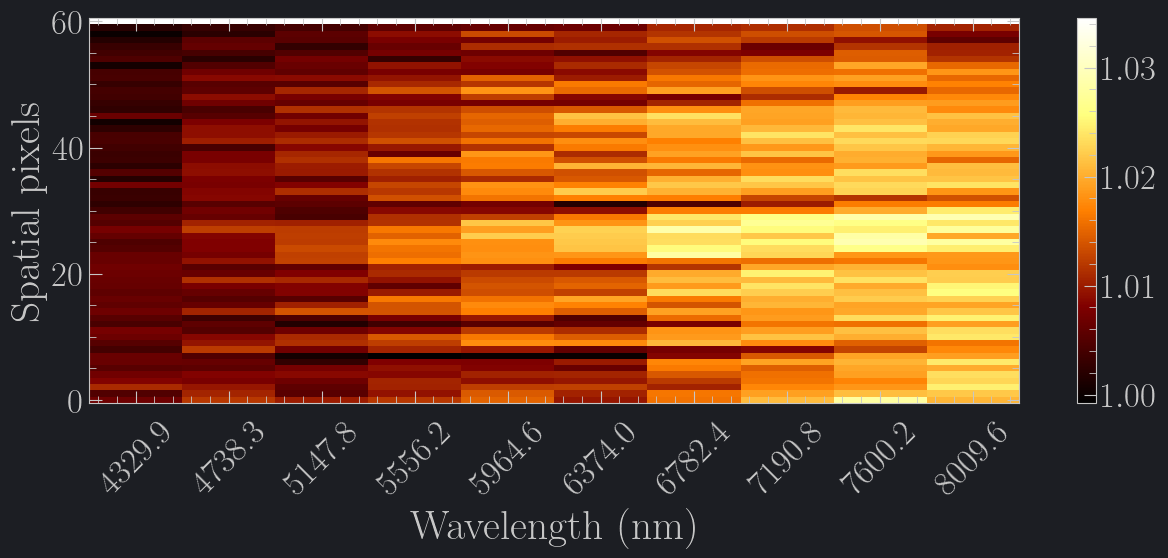

In [17]:
fig, ax = plt.subplots(figsize=(15,5))
# Plot 2D
im, norm = imshow_norm(SNR_binned, ax=ax, aspect='auto', origin='lower', 
                       interval=ZScaleInterval(contrast=0.5),
                       cmap='afmhot',
                       interpolation='none')

plt.colorbar(im)
ax = plt.gca()

# ax.axhline(cen_reg_low, ls='--', color='C0')
# ax.axhline(cen_reg_upp, ls='--', color='C0')
# ax.axhline(sky_reg_low, ls=':', color='C0')
# ax.axhline(sky_reg_upp, ls=':', color='C0')

ax.set_xticks(np.arange(len(wvlg_bins_med)))
ax.set_xticklabels([f"{w:.1f}" for w in wvlg_bins_med], rotation=45)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Spatial pixels')

plt.show()

In [12]:
def rebin_2D(spectrum, bin_wvlg=2, bin_spat=1):
    # Check that the input spectrum is a 2D numpy array
    if not isinstance(spectrum, np.ndarray) or spectrum.ndim != 2:
        raise ValueError("Input spectrum must be a 2D numpy array")
    
    # Check that bin_wvlg and bin_spat are positive integers
    if not isinstance(bin_wvlg, int) or bin_wvlg <= 0:
        raise ValueError("Wavelength bin must be a positive integer")
    
    if not isinstance(bin_spat, int) or bin_spat <= 0:
        raise ValueError("Spatial bin must be a positive integer")
    
    # Determine the number of bins in the rebinned spectrum
    nbins_wvlg = spectrum.shape[1] // bin_wvlg
    nbins_spat = spectrum.shape[0] // bin_spat
    
    # Reshape the spectrum into a 2D array with the new bin width and height
    spectrum_rebinned = spectrum[:nbins_spat*bin_spat, :nbins_wvlg*bin_wvlg].reshape(nbins_spat, bin_spat, nbins_wvlg, bin_wvlg)
    
    # Take the mean of the values in each bin to get the rebinned spectrum
    rebinned_spectrum = np.nansum(np.nansum(spectrum_rebinned, axis=1), axis=2)
    
    return rebinned_spectrum

/var/folders/r1/qchx86rn3tx643ytrjxf6pmm0000gn/T/ipykernel_53198/1794170025.py:1: RuntimeWarning: invalid value encountered in divide
  SNR_binned2 = rebin_2D(flux/unc, bin_wvlg=10, bin_spat=1)


(77, 1845)


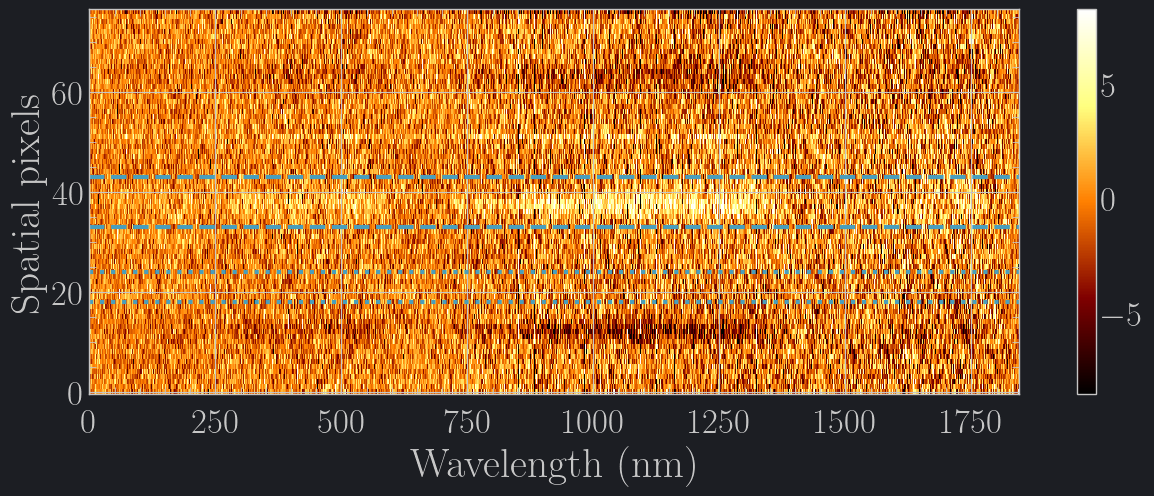

In [13]:
SNR_binned2 = rebin_2D(flux/unc, bin_wvlg=10, bin_spat=1)
print(SNR_binned2.shape)

fig, ax = plt.subplots(figsize=(15,5))
# Plot 2D
im, norm = imshow_norm(SNR_binned2, ax=ax, aspect='auto', origin='lower', 
                       interval=ZScaleInterval(contrast=0.5),
                       cmap='afmhot',
                       interpolation='none')

plt.colorbar(im)
ax = plt.gca()
ax.axhline(cen_reg_low, ls='--', color='C0')
ax.axhline(cen_reg_upp, ls='--', color='C0')
ax.axhline(sky_reg_low, ls=':', color='C0')
ax.axhline(sky_reg_upp, ls=':', color='C0')
# ax.set_xticks(np.arange(len(wvlg_bins_med)))
# ax.set_xticklabels([f"{w:.1f}" for w in wvlg_bins_med], rotation=45)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Spatial pixels')

plt.show()

(77, 1845)


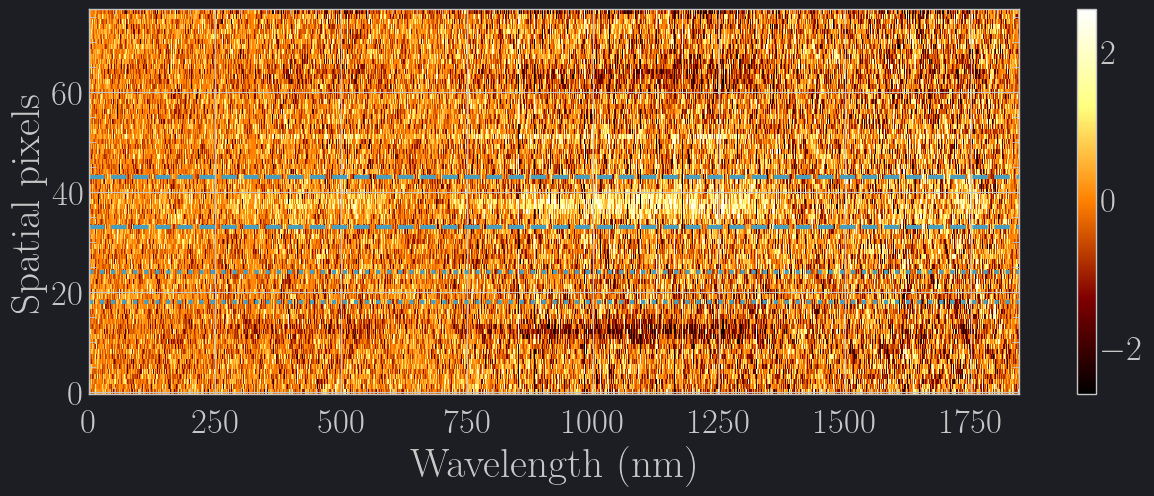

In [14]:
from zhunter.spectral_functions import rebin_spectrum_2d, rebin_spectrum_1d

flux_binned, unc_binned = rebin_spectrum_2d(flux, uncertainty=unc, binning_factors=(1,10))
print(SNR_binned2.shape)

fig, ax = plt.subplots(figsize=(15,5))
# Plot 2D
im, norm = imshow_norm(flux_binned/unc_binned, ax=ax, aspect='auto', origin='lower', 
                       interval=ZScaleInterval(contrast=0.5),
                       cmap='afmhot',
                       interpolation='none')

plt.colorbar(im)
ax = plt.gca()
ax.axhline(cen_reg_low, ls='--', color='C0')
ax.axhline(cen_reg_upp, ls='--', color='C0')
ax.axhline(sky_reg_low, ls=':', color='C0')
ax.axhline(sky_reg_upp, ls=':', color='C0')
# ax.set_xticks(np.arange(len(wvlg_bins_med)))
# ax.set_xticklabels([f"{w:.1f}" for w in wvlg_bins_med], rotation=45)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Spatial pixels')

plt.show()

## Bin 2D flux array in spatial dimension

/var/folders/r1/qchx86rn3tx643ytrjxf6pmm0000gn/T/ipykernel_53198/540998704.py:1: RuntimeWarning: invalid value encountered in divide
  center_trace = np.nanmedian(flux[cen_reg_low:cen_reg_upp]/unc[cen_reg_low:cen_reg_upp],axis=0)
/Users/palmerio/opt/miniconda3/envs/astropalmerio_dev/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/var/folders/r1/qchx86rn3tx643ytrjxf6pmm0000gn/T/ipykernel_53198/540998704.py:2: RuntimeWarning: invalid value encountered in divide
  sky_trace = np.nanmedian(flux[sky_reg_low:sky_reg_upp]/unc[sky_reg_low:sky_reg_upp],axis=0)


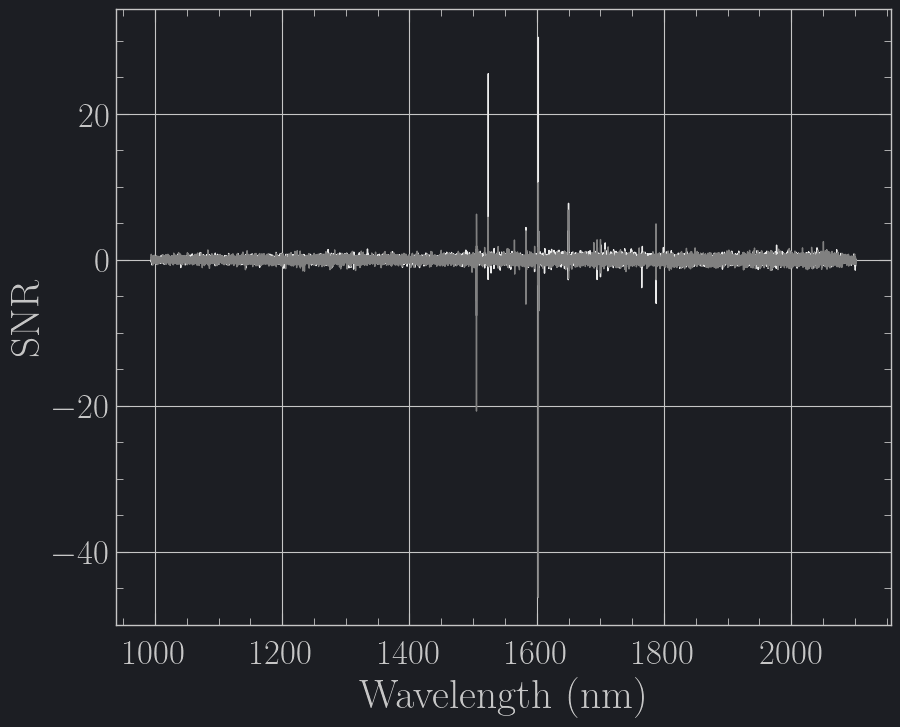

In [15]:
center_trace = np.nanmedian(flux[cen_reg_low:cen_reg_upp]/unc[cen_reg_low:cen_reg_upp],axis=0)
sky_trace = np.nanmedian(flux[sky_reg_low:sky_reg_upp]/unc[sky_reg_low:sky_reg_upp],axis=0)
# negative_nod_trace_a = 
# negative_nod_trace_b = 

fig, ax = plt.subplots()
ax.plot(wvlg, center_trace, lw=1, c='C12')
ax.plot(wvlg, sky_trace, lw=1, c='gray')

ax.set_ylabel('SNR')
ax.set_xlabel('Wavelength (nm)')

plt.show()

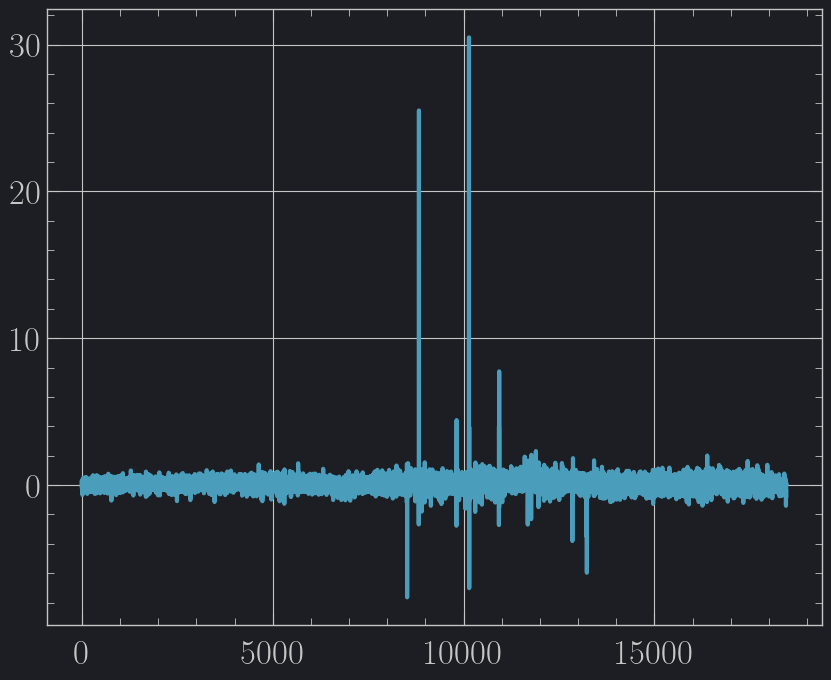

In [16]:
fig, ax = plt.subplots()

for bf in range(1,2):
    center_trace_rb = rebin_spectrum_1d(center_trace, binning_factor=bf)
    ax.plot(center_trace_rb)
    

In [17]:
cen_peaks, cen_properties = find_peaks(center_trace, prominence=2, width=[10,100])
sky_peaks, sky_properties = find_peaks(sky_trace, prominence=2, width=[10,100])


In [18]:
cen_peaks

array([ 4942,  8545,  9182, 10311, 10489, 10764, 10851, 11687, 11969,
       12575, 16381])

In [19]:
sky_peaks

array([ 3972,  9595, 10952, 12479])

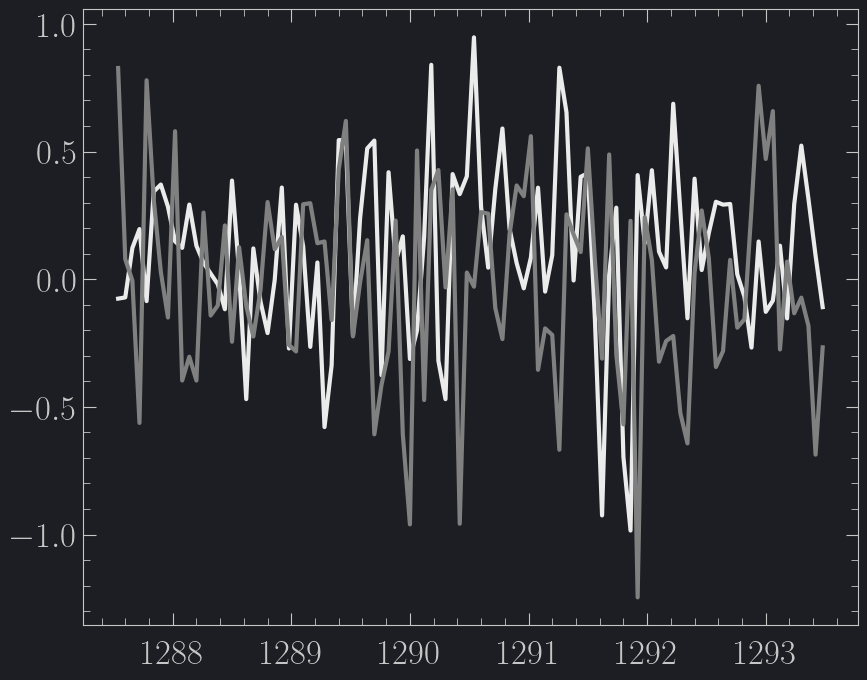

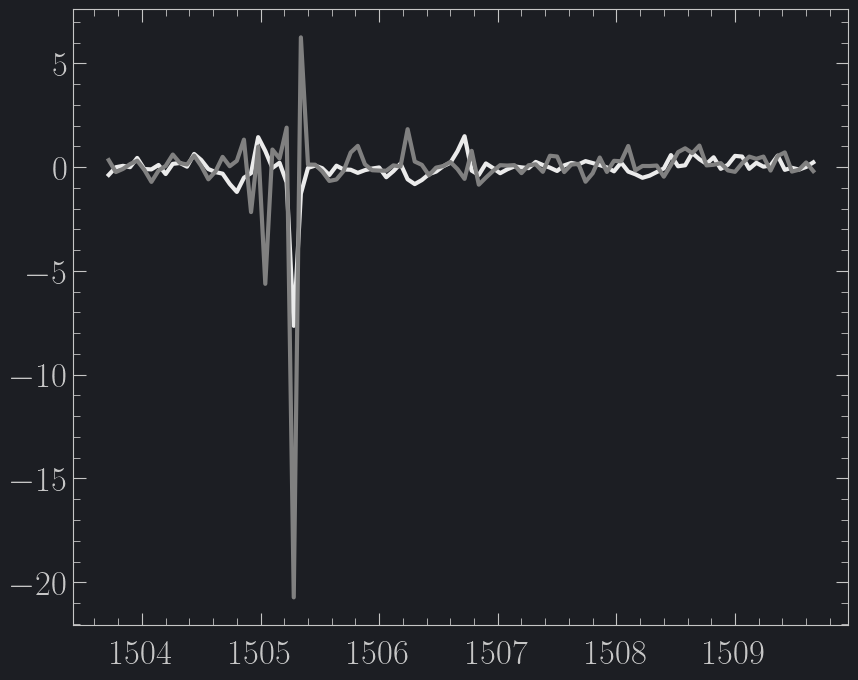

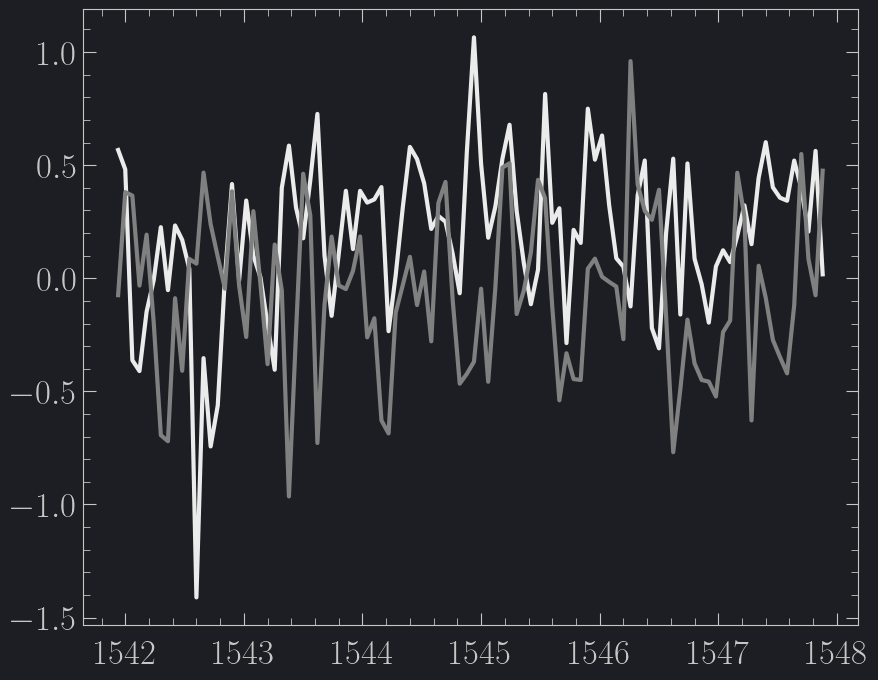

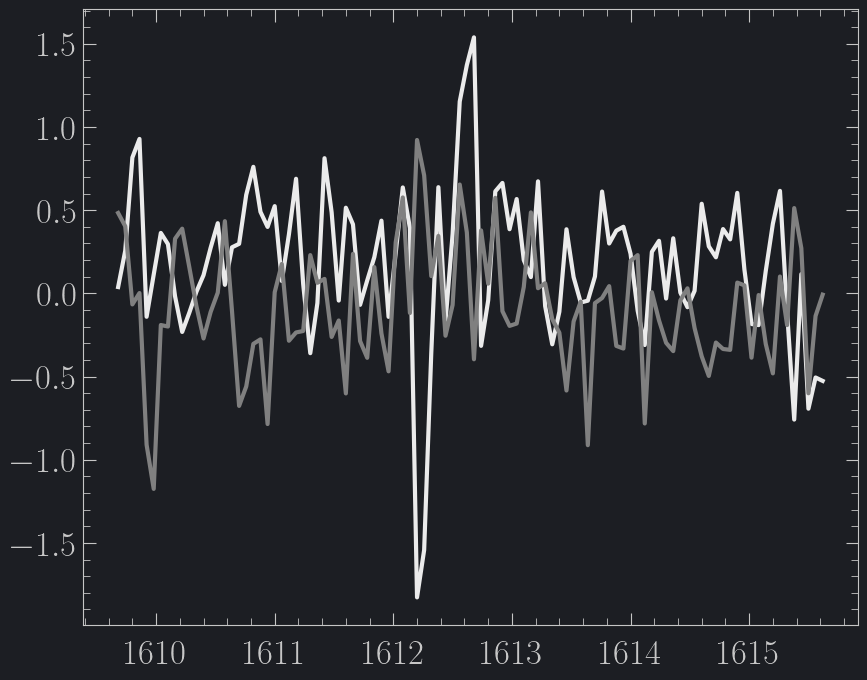

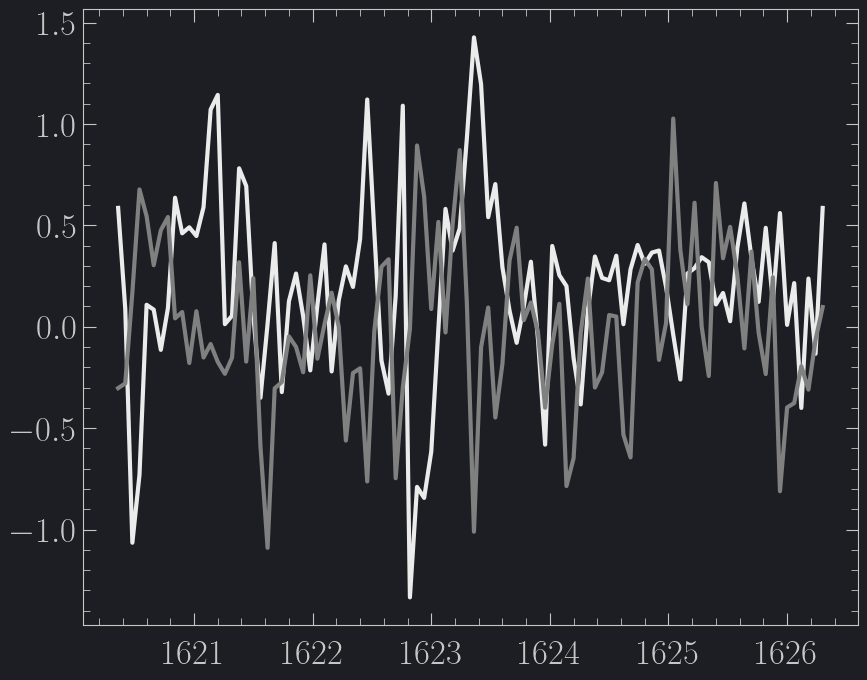

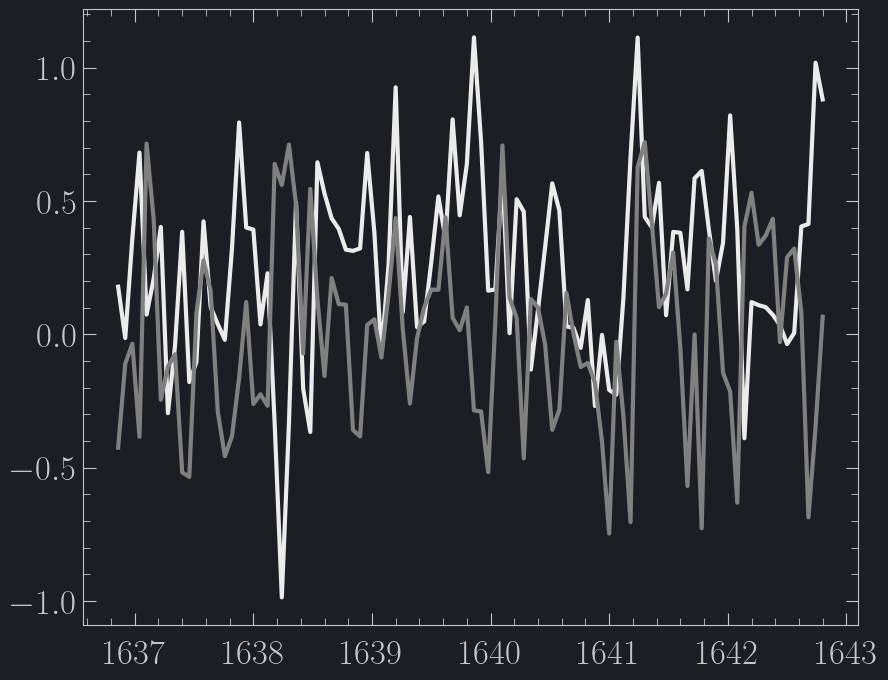

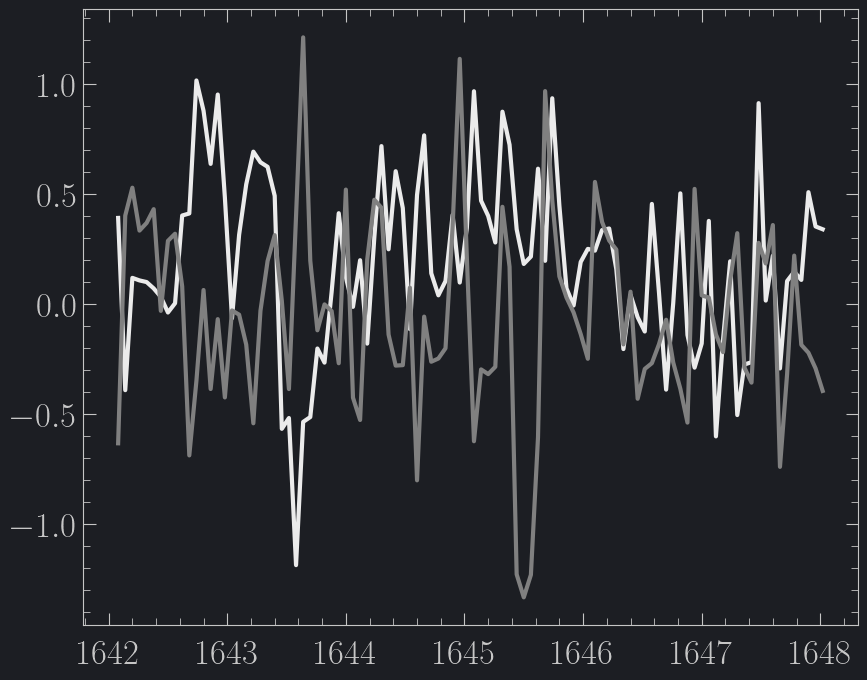

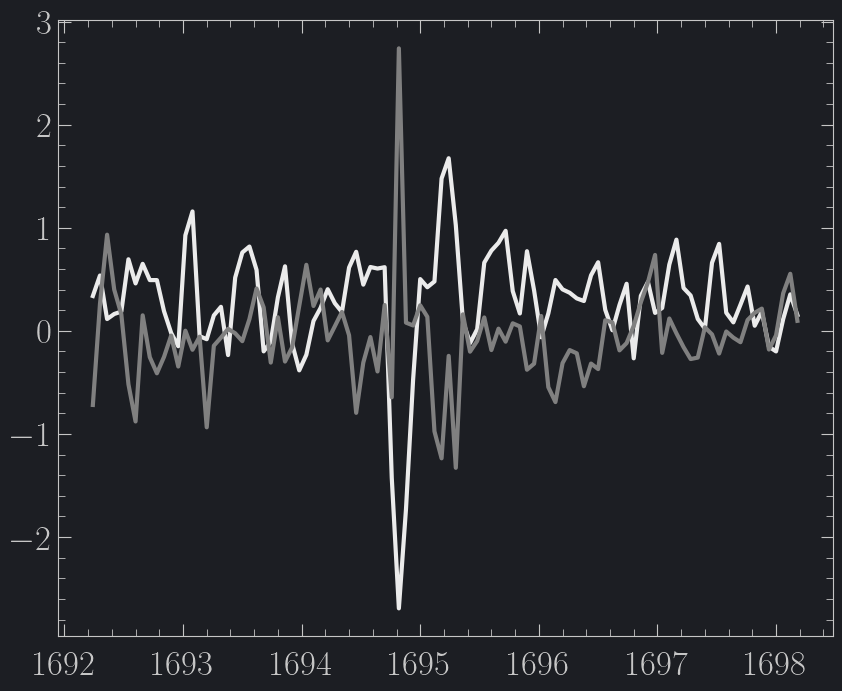

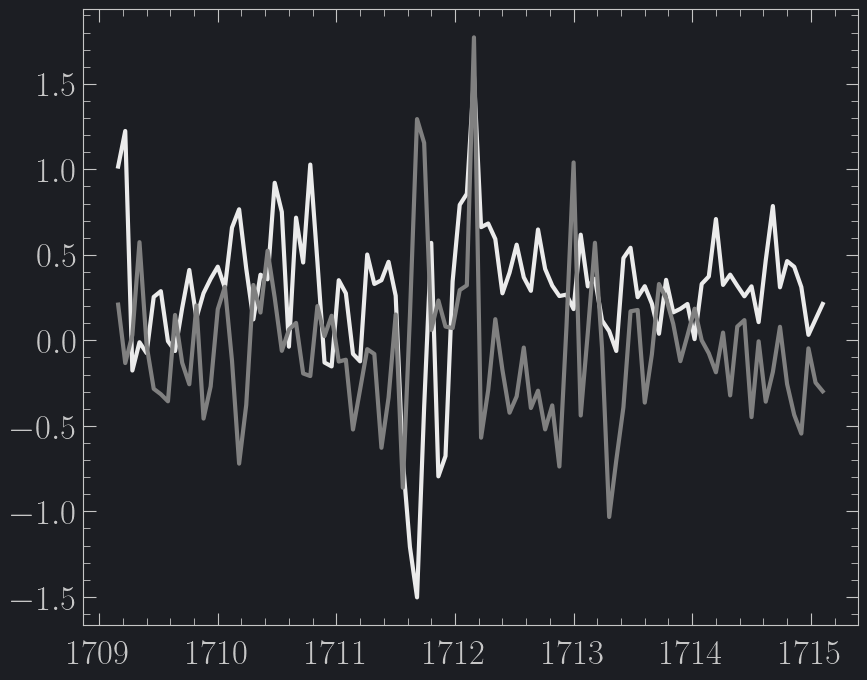

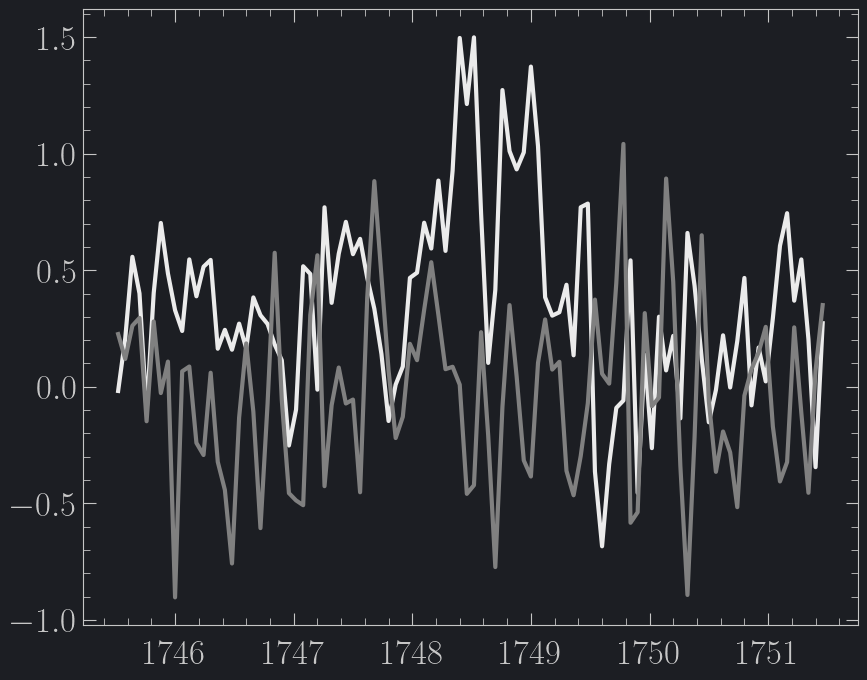

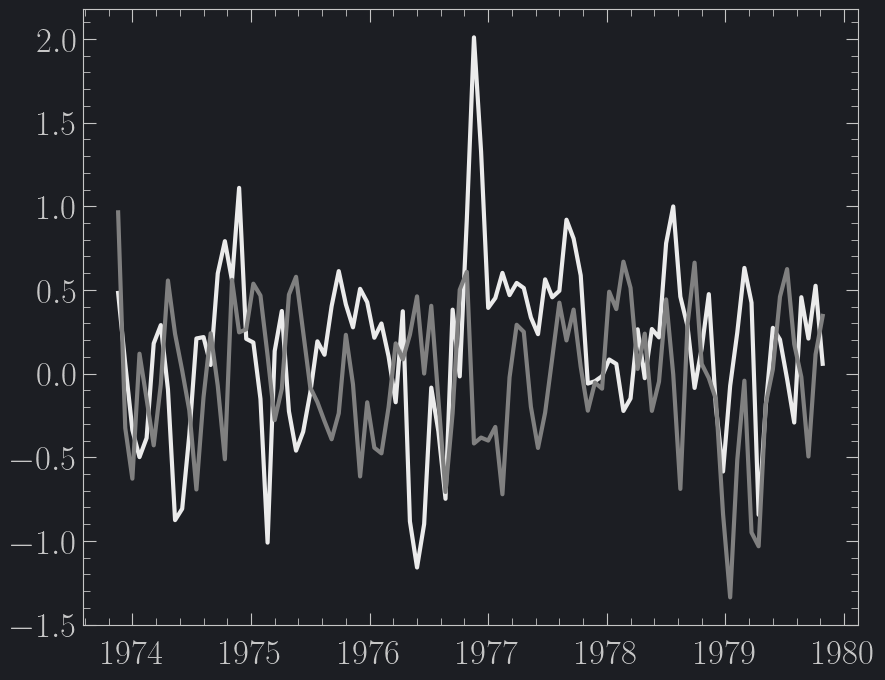

In [77]:
px2view = 50
for pk in cen_peaks:
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(wvlg[pk-px2view:pk+px2view], center_trace[pk-px2view:pk+px2view], color='C12')
    ax.plot(wvlg[pk-px2view:pk+px2view], sky_trace[pk-px2view:pk+px2view], color='gray')
    
plt.show()

In [20]:
from scipy.signal import find_peaks, peak_widths
def find_peaks_2d(spectrum, spatial_width, spectral_width, spatial_prominence, spectral_prominence, spatial_distance, spectral_distance):
    """Finds peaks in a 2D spectrum represented by a NumPy array that
    meet the given width, prominence, and distance criteria in both the
    spatial and spectral dimensions, and are located close to each other
    in both dimensions."""
    # Find the peaks in the spatial dimension.
    spatial_peaks, _ = find_peaks(spectrum.max(axis=1), width=spatial_width, prominence=spatial_prominence, distance=spatial_distance)
    # Find the peaks in the spectral dimension.
    spectral_peaks, _ = find_peaks(spectrum.max(axis=0), width=spectral_width, prominence=spectral_prominence, distance=spectral_distance)
    # Find the maximum values at the spatial and spectral peak locations.
    spatial_peak_vals = spectrum.max(axis=1)[spatial_peaks]
    spectral_peak_vals = spectrum.max(axis=0)[spectral_peaks]
    # Find the widths of the peaks in the spatial and spectral dimensions.
    spatial_peak_widths, _, _, _ = peak_widths(spectrum.max(axis=1), spatial_peaks)
    spectral_peak_widths, _, _, _ = peak_widths(spectrum.max(axis=0), spectral_peaks)
    # Filter the peaks based on the width criteria in both dimensions.
    spatial_peaks = spatial_peaks[spatial_peak_widths >= spatial_width]
    spectral_peaks = spectral_peaks[spectral_peak_widths >= spectral_width]
    # Combine the spatial and spectral peak locations based on their proximity in both dimensions.
    peaks = []
    for spatial_peak in spatial_peaks:
        for spectral_peak in spectral_peaks:
            spatial_distance = abs(spatial_peak - spectral_peak)
            spectral_distance = abs(spectrum[:, spectral_peak].argmax() - spectrum[spatial_peak].argmax())
            if spatial_distance <= spatial_width and spectral_distance <= spectral_width:
                peaks.append([spatial_peak, spectral_peak])
    # Return the peak locations as a NumPy array.
    peaks = np.array(peaks)
    return peaks


In [23]:
# The fake data
N_data = 101
N_spat = 81
seeing = 1.2  # arcsec
seeing_px = seeing/cdelt2
nod_throw = 5
SNR = 10
fscale = 1e-17
# Standard fits stuff
cdelt2 = 0.16  # arcsec per pixel
cdelt1 = 0.02  # nm per pixel

In [24]:
wvlg_bins = np.linspace(600, 700, N_data)
wvlg_step = wvlg_bins[1]-wvlg_bins[0]
wvlg = 0.5*(wvlg_bins[1:]+wvlg_bins[:-1])
spat_bins = np.linspace(-10, 5, N_spat)
spat_step = spat_bins[1]-spat_bins[0]
spat = 0.5*(spat_bins[1:]+spat_bins[:-1])
flux = np.zeros((wvlg.shape[0], spat.shape[0]))

em_line_1D = sp.gaussian_fct(wvlg, mean=656.28, stddev=1, amplitude=3)
trace_profile = sp.gaussian_fct(spat, mean=np.median(spat), stddev=sp.fwhm_to_sigma(seeing), amplitude=1)
neg_trace_profile_u = -sp.gaussian_fct(spat, mean=np.median(spat)+nod_throw, stddev=sp.fwhm_to_sigma(seeing), amplitude=1)
neg_trace_profile_l = -sp.gaussian_fct(spat, mean=np.median(spat)-nod_throw, stddev=sp.fwhm_to_sigma(seeing), amplitude=1)

# Center trace
trace = trace_profile * np.ones((wvlg.shape[0], spat.shape[0]))
trace = trace.T
# add an emission line
em_line = np.outer(
    trace_profile.reshape(len(spat),1),
    em_line_1D.reshape(len(wvlg),1)
)
trace += em_line

# Negative traces to mimick nodding
neg_trace_l = neg_trace_profile_l* np.ones((wvlg.shape[0], spat.shape[0]))
neg_trace_u = neg_trace_profile_u* np.ones((wvlg.shape[0], spat.shape[0]))
neg_trace_l = neg_trace_l.T
neg_trace_u = neg_trace_u.T
# add an emission line
neg_em_line_l = np.outer(
    neg_trace_profile_l.reshape(len(spat),1),
    em_line_1D.reshape(len(wvlg),1)
)
neg_em_line_u = np.outer(
    neg_trace_profile_u.reshape(len(spat),1),
    em_line_1D.reshape(len(wvlg),1)
)
neg_trace_l += neg_em_line_l
neg_trace_u += neg_em_line_u

# add noise
flux += np.random.normal(0, 1./SNR, size=(wvlg.shape[0], spat.shape[0]))
flux = flux.T
flux += trace + neg_trace_l + neg_trace_u
flux *= fscale
unc = fscale/SNR*np.ones(flux.shape)

# wvlg_tell = wvlg
# wvlg_sky_bkg = wvlg
# tellurics = 1 - np.exp(-(wvlg-600)**2/(30)**2)
# sky_bkg = np.exp(-(wvlg-800)**2/(10)**2)

In [25]:
spat_low = np.median(spat) - seeing
spat_upp = np.median(spat) + seeing
i_low = spat.searchsorted(spat_low)
i_upp = spat.searchsorted(spat_upp)
log.info(
    f"Extracting central trace from {spat_low:.1f} to {spat_upp:.1f} arcsec (pixels {i_low} to {i_upp})"
)
center_SNR_traces = flux[i_low:i_upp,:]/unc[i_low:i_upp,:]

2023-04-11 16:29:30,826 INFO [__main__] Extracting central trace from -3.7 to -1.3 arcsec (pixels 34 to 46)


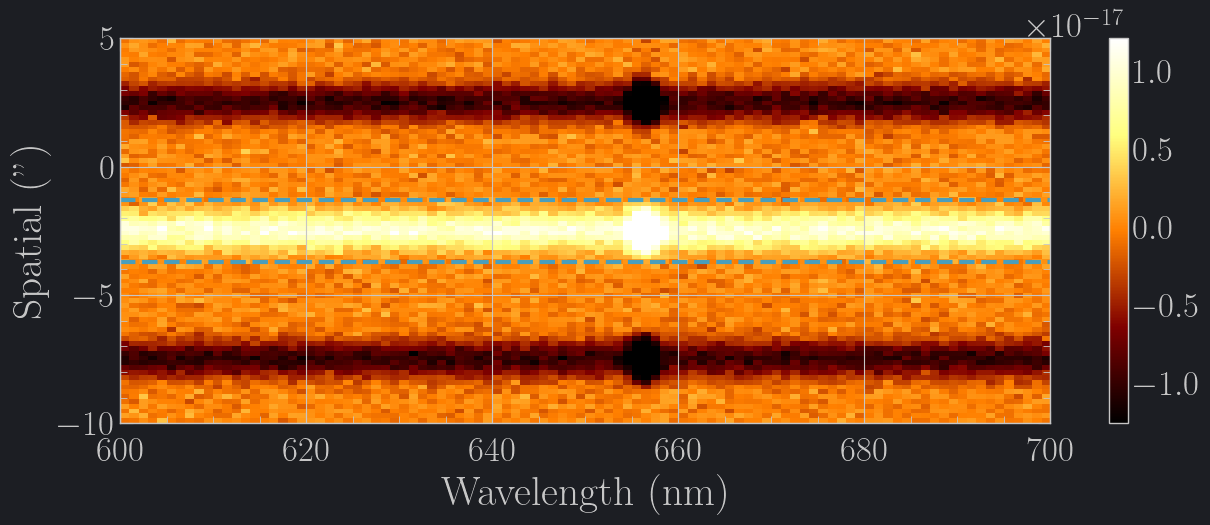

In [26]:
plt.style.use('kraken')
plt.style.use('paper')
fig, ax = plt.subplots(figsize=(15,5))
# Plot 2D
im, norm = imshow_norm(flux, ax=ax, aspect='auto', origin='lower', 
                       extent=[
                           wvlg_bins[0],
                           wvlg_bins[-1],
                           spat_bins[0],
                           spat_bins[-1],
                       ],
                       interval=ZScaleInterval(contrast=0.5),
                       cmap='afmhot',
                       interpolation='none',
                      )

plt.colorbar(im)
ax = plt.gca()
ax.axhline(spat_low, ls='--', color='C0')
ax.axhline(spat_upp, ls='--', color='C0')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Spatial (")')

plt.show()

In [27]:
## Algorithm parameters in physical units

min_wvlg_fwhm = 0.04 * u.AA
max_wvlg_fwhm = 10 * u.AA
min_SNR = 5
log.info(
    "Initializing peak finding algorithm to seach for peaks with:\n"
    f"{min_wvlg_fwhm:.2f} < FWHM < {max_wvlg_fwhm:.1f}\n"
    f"SNR > {min_SNR}"
)

2023-04-11 16:29:40,258 INFO [__main__] Initializing peak finding algorithm to seach for peaks with:
0.04 Angstrom < FWHM < 10.0 Angstrom
SNR > 5


In [28]:
# Convert to pixels
min_px_fwhm = int(min_wvlg_fwhm.value / cdelt1)
max_px_fwhm = int(max_wvlg_fwhm.value / cdelt1)
log.debug(
    f"Converted peak widths from\n"
    f"{min_wvlg_fwhm.value:.1f} < FWHM < {max_wvlg_fwhm.value:.1f} ({max_wvlg_fwhm.unit}) to:\n"
    f"{min_px_fwhm:d} < FWHM < {max_px_fwhm:d} (pixels)\n"
)

2023-04-11 16:29:41,922 DEBUG [__main__] Converted peak widths from
0.0 < FWHM < 10.0 (Angstrom) to:
2 < FWHM < 500 (pixels)



In [30]:
peaks = []
for trace in center_SNR_traces:
    _peaks, properties = find_peaks(trace, prominence=min_SNR, width=[min_px_fwhm,max_px_fwhm])
    peaks.append(_peaks)

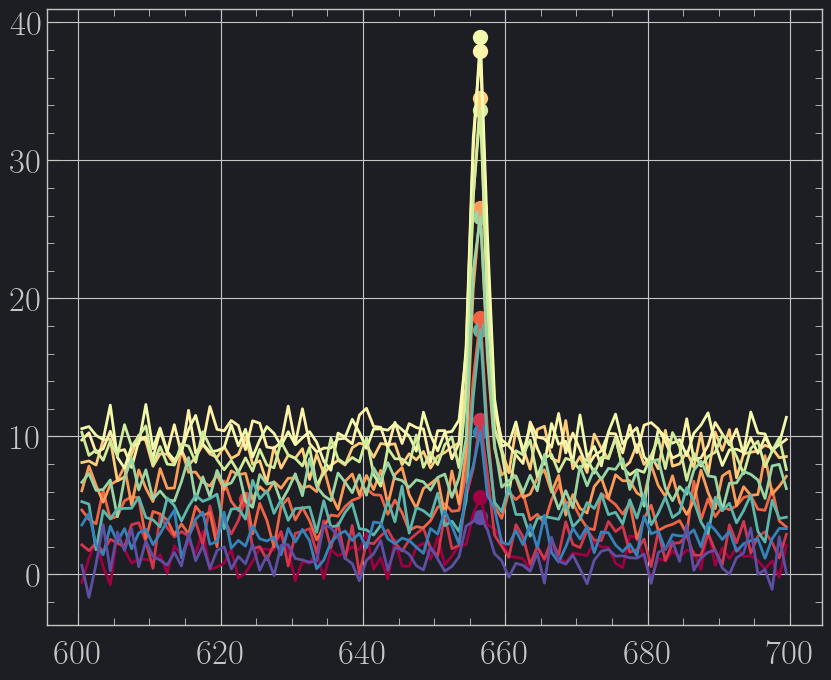

In [31]:
fig, ax = plt.subplots()
colors = cmr.take_cmap_colors('Spectral', center_SNR_traces.shape[0], cmap_range=(0.0, 1), return_fmt='hex')


for i,trace in enumerate(center_SNR_traces):
    ax.plot(wvlg, trace, color=colors[i], lw=2)
    ax.scatter(wvlg[peaks[i]], trace[peaks[i]], color=colors[i])

plt.show()

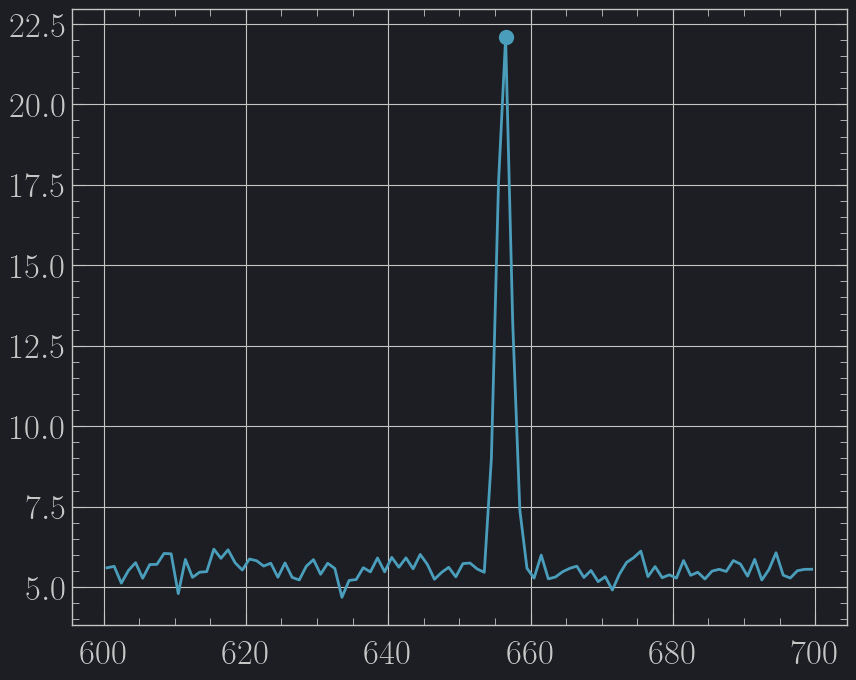

In [32]:
fig, ax = plt.subplots()

trace_summed = np.mean(center_SNR_traces, axis=0)
pks_summed, _ = find_peaks(trace_summed, prominence=min_SNR, width=[min_px_fwhm,max_px_fwhm])
ax.plot(wvlg, trace_summed, color='C0', lw=2)
ax.scatter(wvlg[pks_summed], trace_summed[pks_summed], color='C0')

plt.show()